In [1]:
%matplotlib inline
import time,json,os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from common import preprocess,get_csv_files
from warnings import filterwarnings
from scipy.stats import pearsonr,spearmanr,kendalltau
import matplotlib.pyplot as plt
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.4f' % x)
plt.rcParams['axes.unicode_minus'] = False
plt.style.use({'figure.figsize':(12, 4)})

In [2]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    plt.xticks(rotation=60)

In [3]:
def get_similary(d1,d2,metric):
    mask = (df_simi['D1'] == d1) & (df_simi['D2'] == d2)
    return df_simi[mask][metric].tolist()[0]

In [4]:
df_perf = pd.read_csv("/data/dataset/analyse/validation.csv",index_col=0)
df_simi = pd.read_csv("/data/dataset/analyse/similarity.csv",index_col=0)

In [5]:
all_data = []
for d1 in df_perf['train'].unique():
    for d2 in df_perf['valid'].unique():
        for metric in df_simi.keys():
            if metric in ['D1','D2']:
                continue
            similar = get_similary(d1,d2,metric)
            for model in df_perf['model'].unique():
                mask = ( df_perf['train'] == d1 ) & ( df_perf['valid'] == d2 ) & ( df_perf['model'] == model )
                tmp = {}
                tmp['d1'] = d1
                tmp['d2'] = d2
                tmp['simi'] = similar
                tmp['metric'] = metric
                tmp['model'] = model
                for key in ['recall','mcc','accuracy','precision','auc','f1_score','fbeta_score','log_loss']:
                    tmp[key] = df_perf[mask][key].tolist()[0]
                all_data.append(tmp)
    print(d1)
df_all = pd.DataFrame(all_data)
df_all_scaled = df_all.copy( deep = True )
for key in df_all_scaled.keys():
    if not key in ['d1','d2','model','metric']:
        df_all_scaled[key] = (df_all_scaled[key]-df_all_scaled[key].mean())/(df_all_scaled[key].max()-df_all_scaled[key].min())

base-3-2-train-1
base-0-1-train-1
base-3-1-train-1
base-1-1-train-1


In [6]:
def plot_correlation(model,metric,train_sample,score):
    mask = ( df_all['model'] == model ) & ( df_all['metric'] == metric ) & ( df_all['d1'] == train_sample )
    df_test = df_all[mask].sort_values(by=['d2']).reset_index( drop = True )
    corr = spearmanr(df_test['simi'],df_test[score])
    print("spearmanr:",corr[0],corr[1])
    corr = pearsonr(df_test['simi'],df_test[score])
    print("pearsonr:",corr[0],corr[1])
    corr = kendalltau(df_test['simi'],df_test[score])
    print("kendalltau:",corr[0],corr[1])
    
    fig,ax = plt.subplots(3,1,figsize=(16,12))
    fig.subplots_adjust(hspace = 1)
    sns.set( font_scale = 1 )
    sns.barplot(x=df_test.index, y="simi", data=df_test, ax=ax[0])
    ax[0].title.set_text("%s:%s (%s:%s)"%(model,"distance", train_sample, metric))
    ax[0].set_xticklabels(labels=df_test.d2,rotation=45)
    
    sns.barplot(x=df_test.index, y=score, data=df_test, ax=ax[1])
    ax[1].title.set_text("%s:%s (%s:%s)"%(model,score, train_sample,metric))
    ax[1].set_xticklabels(labels=df_test.d2,rotation=45)

    df_bin = df_test.copy( deep = True )
    tmp = pd.qcut( df_test[score] , 6 )
    tmp_bin = []
    for item in tmp:
        txt = "%06f-%06f"%(item.left,item.right)
        tmp_bin.append(txt)
    df_bin['score'] = pd.Series(tmp_bin)
    sns.scatterplot(x = score, y = 'simi', hue='score' ,data = df_bin, ax=ax[2])
    ax[2].title.set_text("distance by %s distribution " % score )

    plt.show()

spearmanr: -0.6264705882352941 0.009413977306783632
pearsonr: -0.9580986790054782 5.441965558265587e-09
kendalltau: -0.45 0.015155343637698342


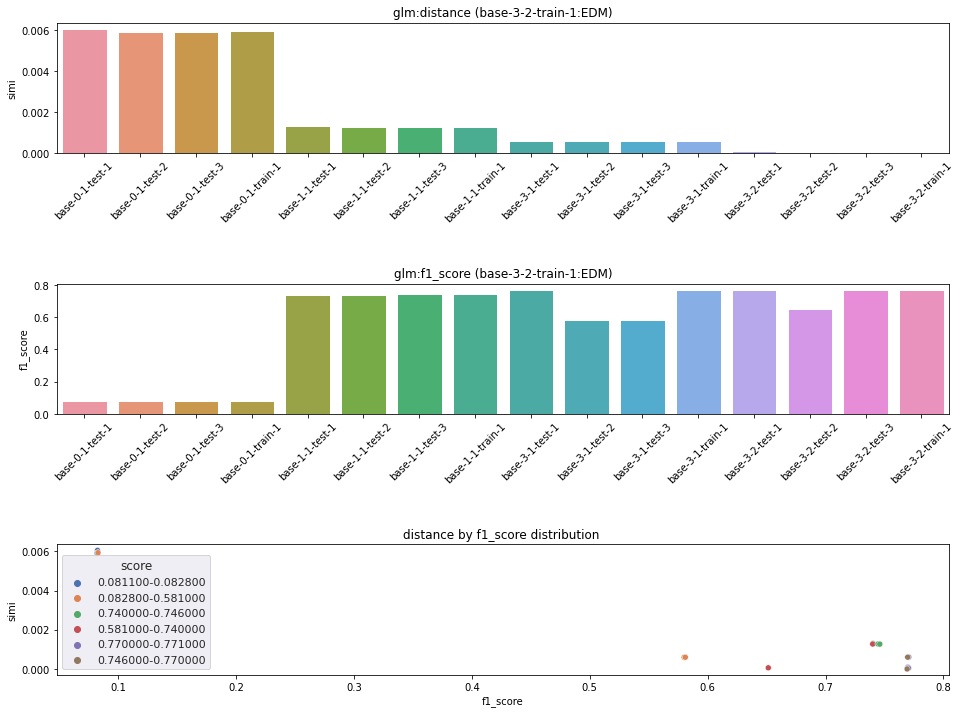

In [7]:
plot_correlation("glm", "EDM", "base-3-2-train-1", "f1_score" )

spearmanr: 0.55 0.027293972709730593
pearsonr: 0.7945445283947116 0.0002360287106532937
kendalltau: 0.39999999999999997 0.03262571359431892


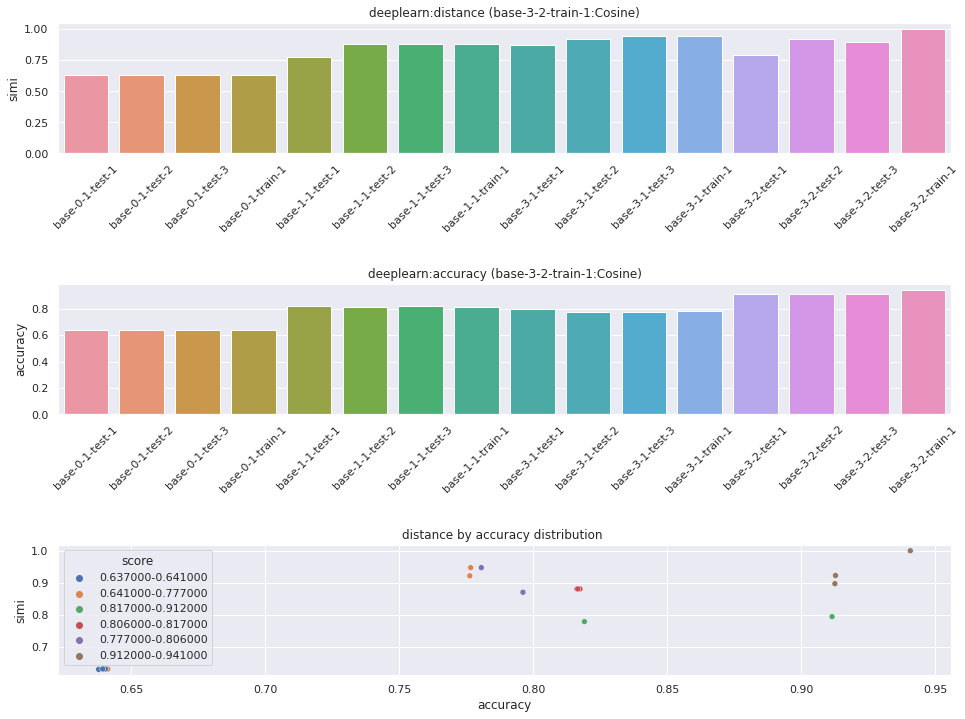

In [8]:
plot_correlation("deeplearn", "Cosine", "base-3-2-train-1", "accuracy" )

spearmanr: 0.7647058823529411 0.0005596762943567445
pearsonr: 0.822323780788474 9.239106593418627e-05
kendalltau: 0.5499999999999999 0.002372163906710451


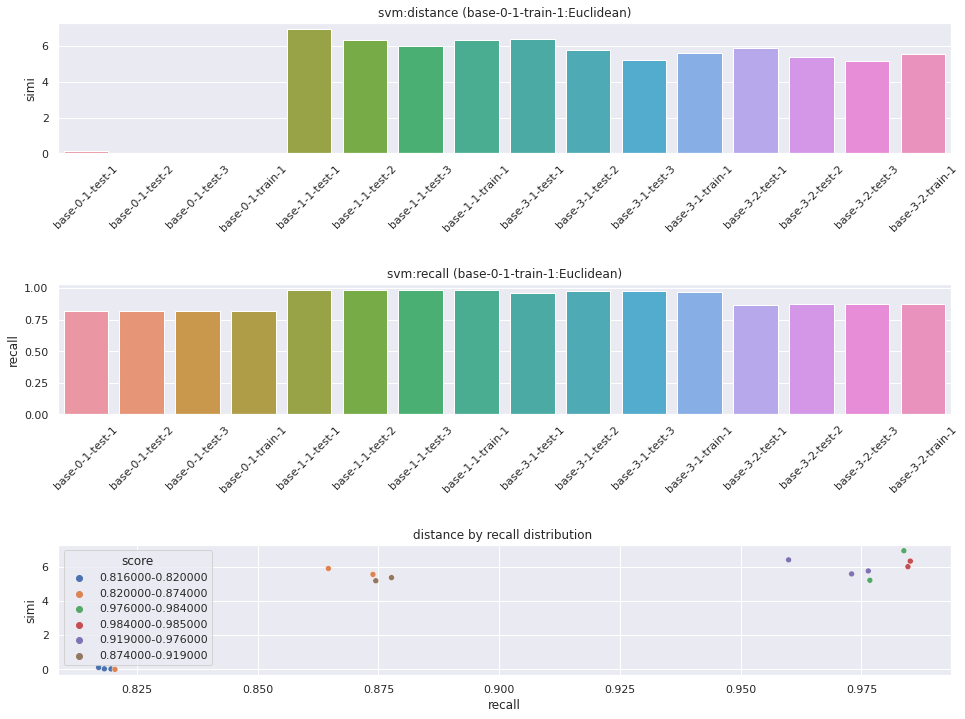

In [9]:
plot_correlation("svm", "Euclidean", "base-0-1-train-1", "recall" )

spearmanr: 0.6264705882352941 0.009413977306783632
pearsonr: 0.9435322032927917 4.225001120401406e-08
kendalltau: 0.4666666666666666 0.011480597067017682


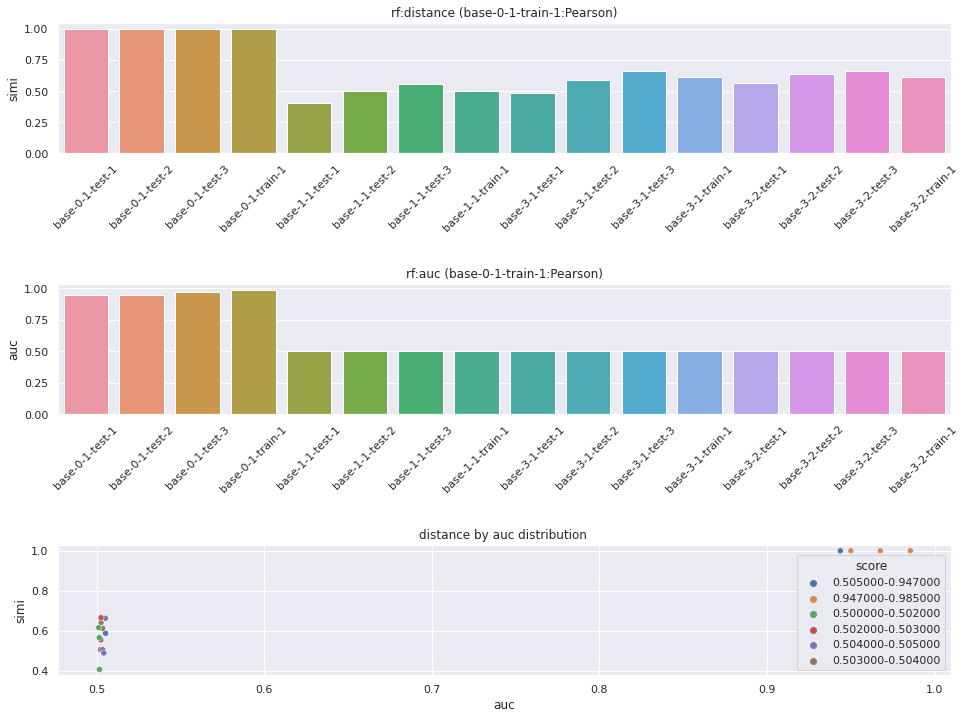

In [10]:
plot_correlation("rf", "Pearson", "base-0-1-train-1", "auc" )